# Исследование продаж игр

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

## Подготовка данных

In [2]:
try:
    data = pd.read_csv("datasets/games.csv")
except:
    print("Не получилось прочитать данные")
data.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Изменение названий столбцов

Для того, чтобы было удобнее работать с данныни необходимо привести названия столбцов к общепринятым нормам

In [3]:
data.columns = data.columns.str.lower()

### Изменение типов данных

#### Предложения по замене типов данных и заполению пропусков

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data[data["rating"].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Заменим типы данных в следующих столбцах
- `year_of_release` из float в int
- `user_score` из object в float  

Пропуски есть в столбцах
- `name` незначительное количесво, можно удалить
- `year_of_release` незначительное количесво, можно удалить
- `genre` незначительное количесво, можно удалить
- `critic_score` можно оставить, но поставить -1
- `user_score` аналогично `critic_score`
- `rating` можно оставить (?)

#### Удаление пропусков

In [6]:
to_trash = ["name", "year_of_release", "genre"]
data.dropna(subset=to_trash, inplace=True)
    
len(data)/16715

0.9837870176488184

Удалили всего 1.6 процента

In [7]:
len(data["name"].unique())

11426

#### Столбец year_of_release

In [8]:
data["year_of_release"] = data["year_of_release"].astype("int")

#### Столбец user_score

Разберёмся, что такое tbd и можно ли с ним что-то сделать

tdb - to be determinate можно заменить пропуски и tbd на -1 и тогда будет возможно заменить тип данных

In [9]:
data.loc[(data["user_score"]=="tbd")|(data["user_score"].isna()), "user_score"] = -1
data["user_score"] = data["user_score"].astype("float")

Поступим аналогично столбцу `user_score`

In [10]:
data.loc[data["critic_score"].isna(), "critic_score"] = -1

#### Столбец rating

Поставим заглушку "ND" (Not Defined) на места пропусков в этом столбце

In [11]:
data["rating"].fillna(value="ND", inplace=True)

#### Проверка явных дубликатов

In [12]:
data.duplicated().sum()

0

Явных дубликатов нет

### Добавление столбца

In [13]:
data["sum_sales"] = data["na_sales"] + data["eu_sales"] + data["jp_sales"] + data["other_sales"]

### Проверка

In [14]:
data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,ND,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,ND,31.38


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
 11  sum_sales        16444 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.6+ MB


Всё как нужно, всё как мы и хотели

In [16]:
# Комментарий ревьюера
# Посмотрим, что у нас осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
 11  sum_sales        16444 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

Пропуски в столбцах `name` `genre` `year_of_release` связаны скорее с ошибкой заполнения/выгрузки данных. Пропуски в столбцах `user_score` и `critic_score` связаны с тем, что это "необязательное поле" - критики могли и не оценить игру или не успеть её оценить, разработчик мог не собирать отзывы пользователей и т.д. В столбце `rating` большое количесво пропусков связаны с той же "необязательностью" - разработчик совсем не обязан посылать свою игру на оценку, да и игры, выпущенные в 80-90-е могли и не застать появления возрастного рейтинга


## Исслeдовательский анализ

### Сколько игр выпускалось в разные годы?

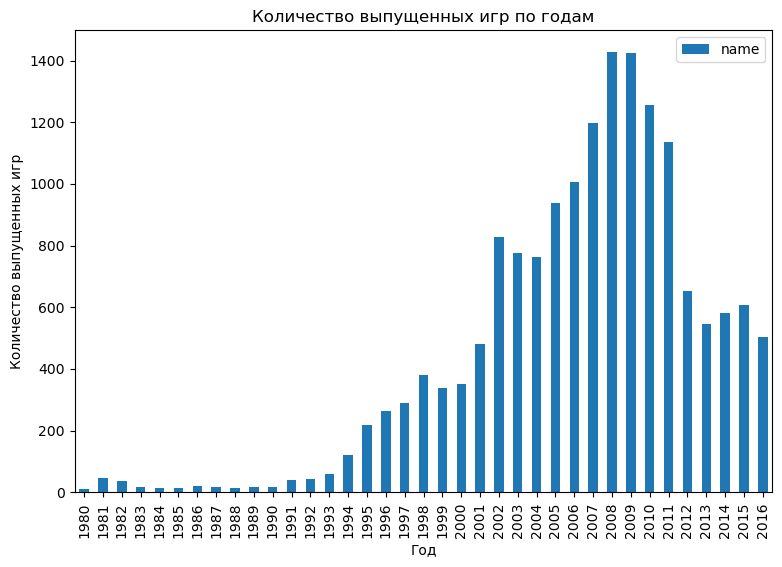

In [17]:
year_of_release = data.pivot_table(index="year_of_release", values = "name", aggfunc="count")
year_of_release.plot(kind="bar", figsize=(9,6))
plt.title("Количество выпущенных игр по годам")
plt.xlabel("Год")
plt.ylabel("Количество выпущенных игр")
plt.show()

До 2008 года выпуск игр стабильно рос, но после 2009 наблюдаем резкий обвал с 1400 игр в 2009 до 500 игр в 2013

последние 4 года не наблюдается однозначной динамики, спрогнозировать выпуск игр на следующий год сложно, но очень грубо можно предположить что это будет около среднее значение за последний 4 года, то есть с 2013 по 2017

### Исследование динамики продаж по платформам

#### Популярные за всё время платформы

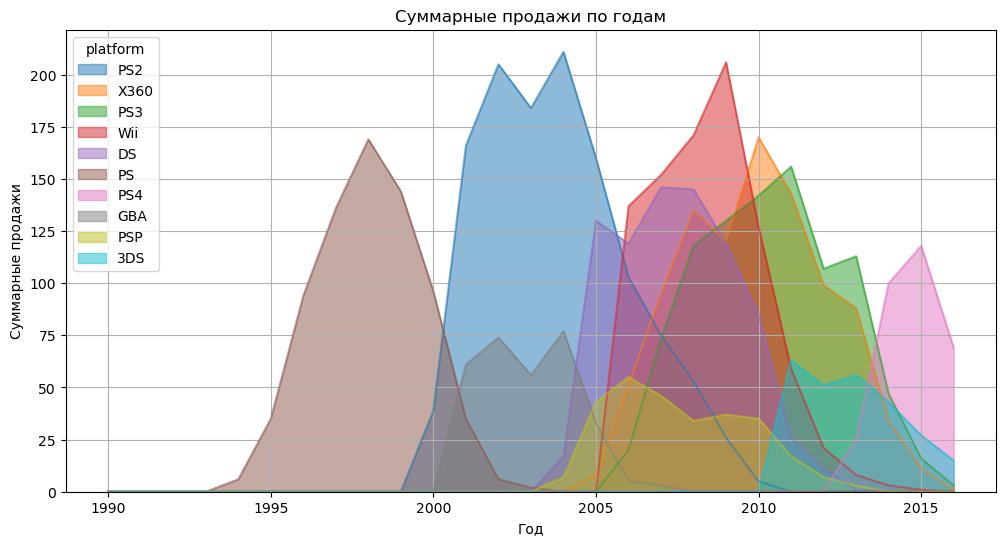

In [18]:
#создаём список из 10 популярных платформ
platforms = list(data.pivot_table(index="platform", values="sum_sales", aggfunc="sum").
                 sort_values(by="sum_sales", ascending=False).head(10).index)

#делаем сводную таблицу количества выпущенных игр на каждой платформе за определённый год
all_platforms_per_years = \
data.pivot_table(index=["year_of_release"], columns="platform", values="sum_sales", aggfunc="sum").fillna(value=0).astype("int")

#оставляем только столбцы с популярными платформами
platforms_per_years = all_platforms_per_years[platforms]
#возьмём данные после 1990 года
platforms_per_years[platforms_per_years.index>=1990].plot(kind="area", stacked=False, figsize=(12,6), grid=True)
plt.title("Суммарные продажи по годам")
plt.xlabel("Год")
plt.ylabel("Суммарные продажи")
plt.show()

Характерный период за который рождается, расцветает и умирает одна платформа - около 10 лет (от 8 до 12)

Странно, что PS4 показывает падение в 2016 году, даже близко не достигнув пика прошлых версий PS. Сделаем смелое предположение, что данные за 2016 год неполные

Можно предположить, что сейчас будет активно расти платфома PS4, а PS3 и X360 уже своё отжили

#### Популярные платформы за последние 4 года

Как отмечалось ранее, динамика продаж игр за последние 4 года сильно отличается от предыдущих лет, поэтому имеет смысл рассмотеть популярные платформы именно за этот период. Попробуем узнать, какая платформа сейчас набирает популярность

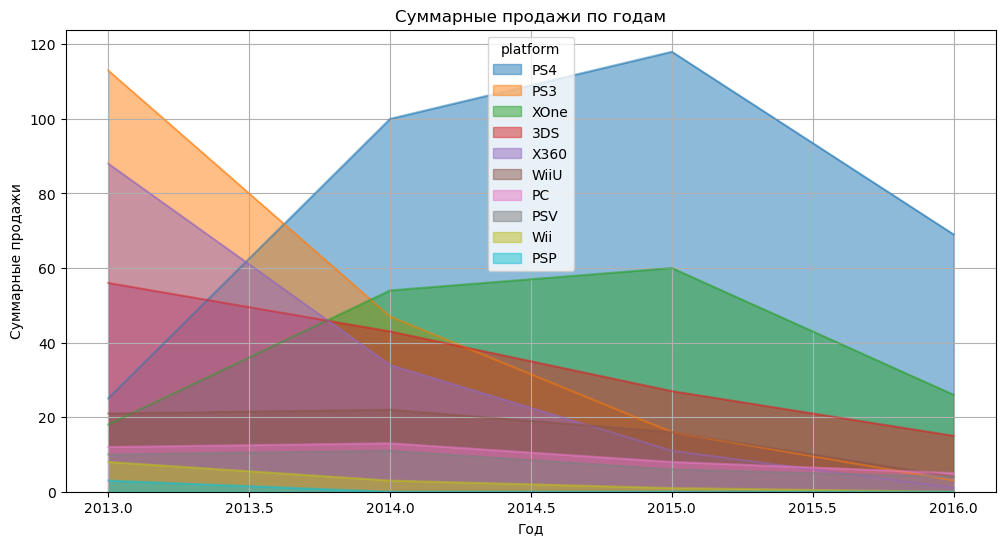

In [19]:
#создаём список из 10 популярных платформ за последние 4 года
platforms = list(data[data["year_of_release"]>=2013].pivot_table(index="platform", values="sum_sales", aggfunc="sum").
                 sort_values(by="sum_sales", ascending=False).head(10).index)

#делаем сводную таблицу количества выпущенных игр на каждой платформе за определённый год
all_platforms_per_years = \
data.pivot_table(
    index=["year_of_release"], columns="platform", values="sum_sales", aggfunc="sum").fillna(value=0).astype("int")

#оставляем только столбцы с популярными платформами
platforms_per_years = all_platforms_per_years[platforms]
#возьмём данные после 2013 года
platforms_per_years[platforms_per_years.index>=2013].plot(kind="area", stacked=False, figsize=(12,6), grid=True)
plt.title("Суммарные продажи по годам")
plt.xlabel("Год")
plt.ylabel("Суммарные продажи")
plt.show()

Почти все платформы последние 4 года только теряют популярность. Но всего три набирают:
- ПК показывыет невысокие, но стабильные продажи с 2012 года
- PS4 растёт с 2012 и будет набирать популярность примерно 5 лет (если учесть наблюдение сделанное ранее)
- Xbox One растёт с 2012 года, но медленне, чем PS4. По характеру кривой интуитивно можно предположить, он начнёт терять популярность быстрее, чем PS4

#### Разница в распределении продаж по платформам

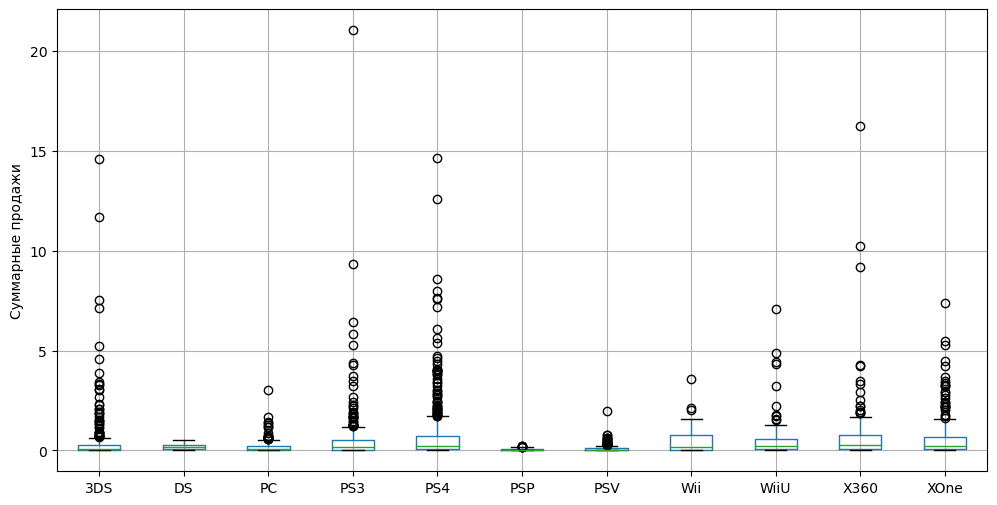

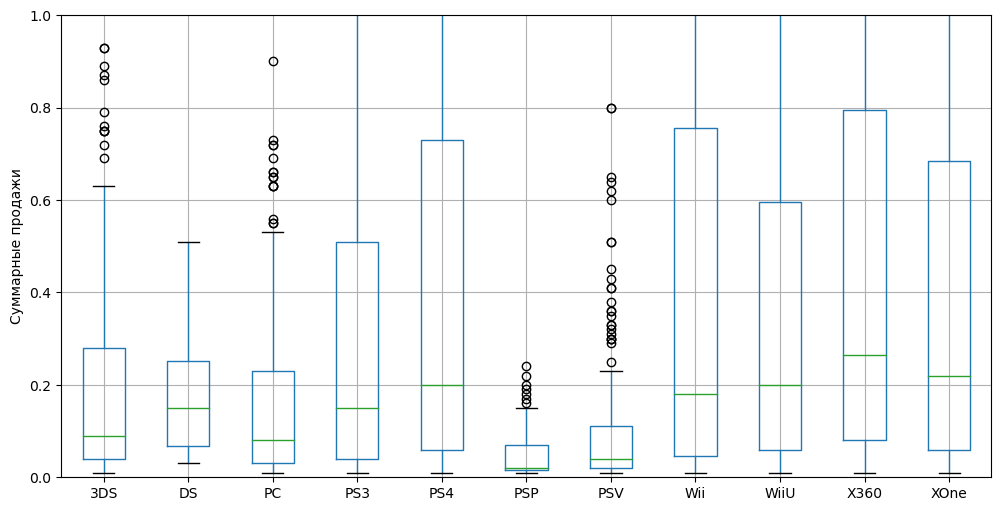

In [20]:
platforms_sales = data[data["year_of_release"]>=2013].pivot_table(
    index="name",columns = "platform",values="sum_sales", aggfunc="sum"
)
platforms_sales.boxplot(figsize=(12,6))
plt.ylabel("Суммарные продажи")
plt.show()
platforms_sales.boxplot(figsize=(12,6))
plt.ylim(0, 1)
plt.ylabel("Суммарные продажи")
plt.show()


За последние 4 года платформа с самой большой медианой по общим продажам была Xbox360, с самой маленькой - PSP. У всех суммарных продаж наблюдается ассиметрия в большую сторону. 

### Связь продаж и отзывов

Рассмотрм одну набирающую популярность платформу - PS4

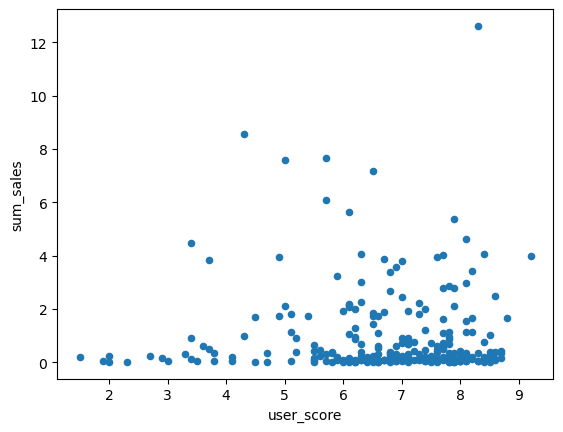

-0.031957110204556424

In [21]:
ps4_data = data[(data["platform"]=="PS4")&(data['user_score']>0)&(data["year_of_release"]>=2013)]
ps4_data.plot(x='user_score', y = "sum_sales", kind="scatter")
plt.show()
ps4_data['user_score'].corr(ps4_data["sum_sales"])

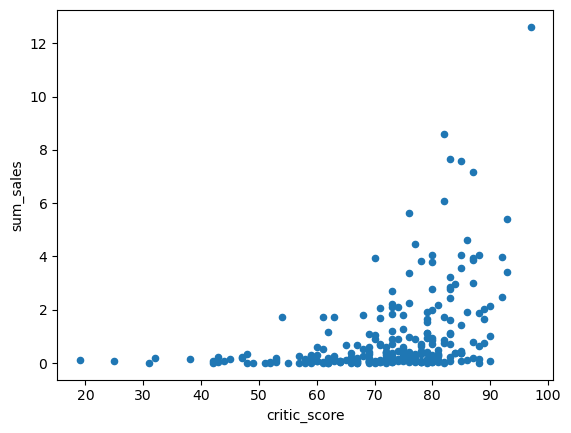

0.40656790206178095

In [22]:
ps4_data = data[(data["platform"]=="PS4")&(data['critic_score']>0)&(data['year_of_release']>=2013)]
ps4_data.plot(x='critic_score', y = "sum_sales", kind="scatter")
plt.show()
ps4_data['critic_score'].corr(ps4_data["sum_sales"])

Получилось, что для PS4 оценки критиков сильнее влияют на количество продаж (или наоборот). Но так ли это для других платформ?
Возьмем 5 популярных платформ за последние 4 года и составим специальную таблицу

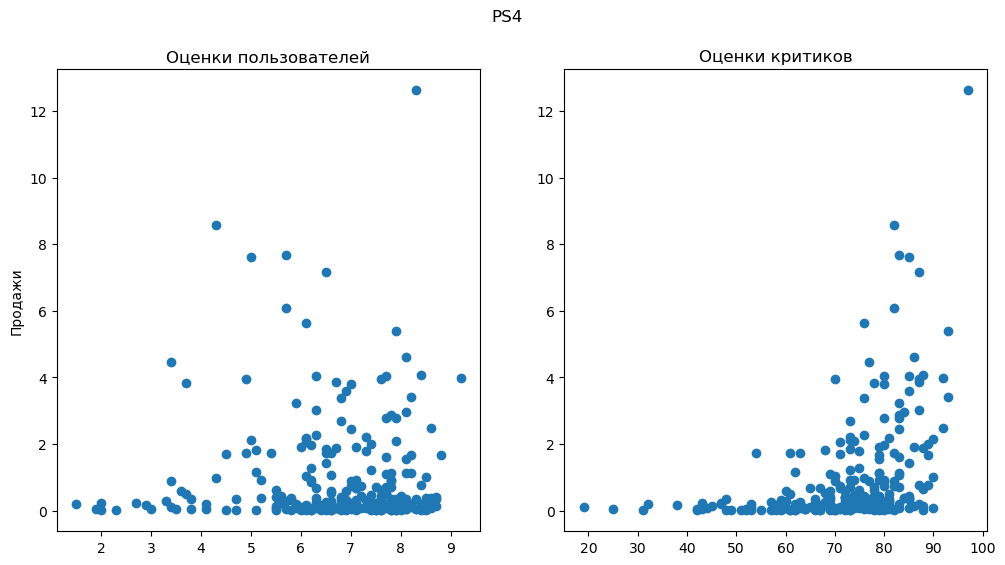

    Корреляция:                                      Корреляция:
    -0.031957110204556424                             0.40656790206178095


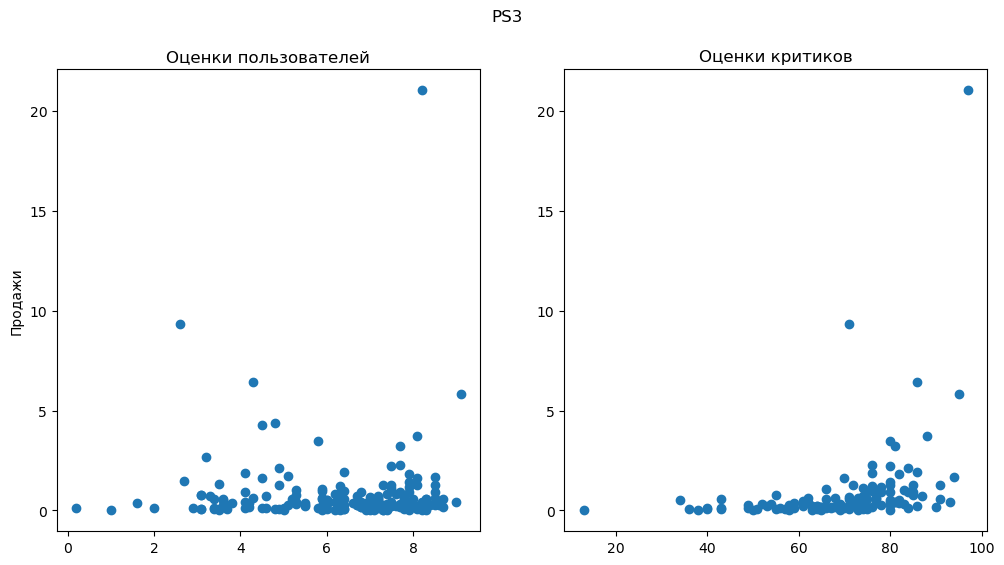

    Корреляция:                                      Корреляция:
    0.0023944027357566925                             0.3342853393371919


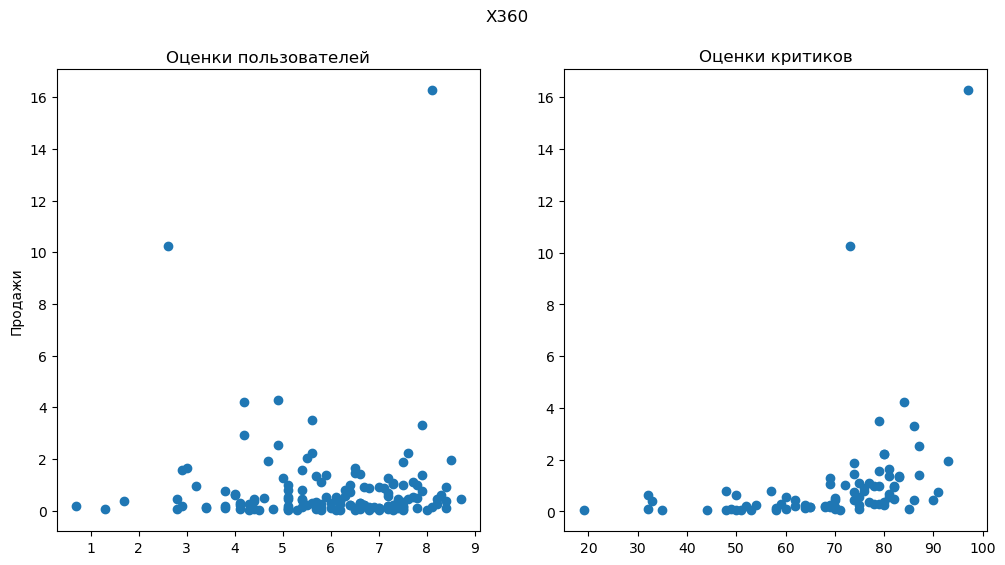

    Корреляция:                                      Корреляция:
    -0.011742185147181342                             0.3503445460228664


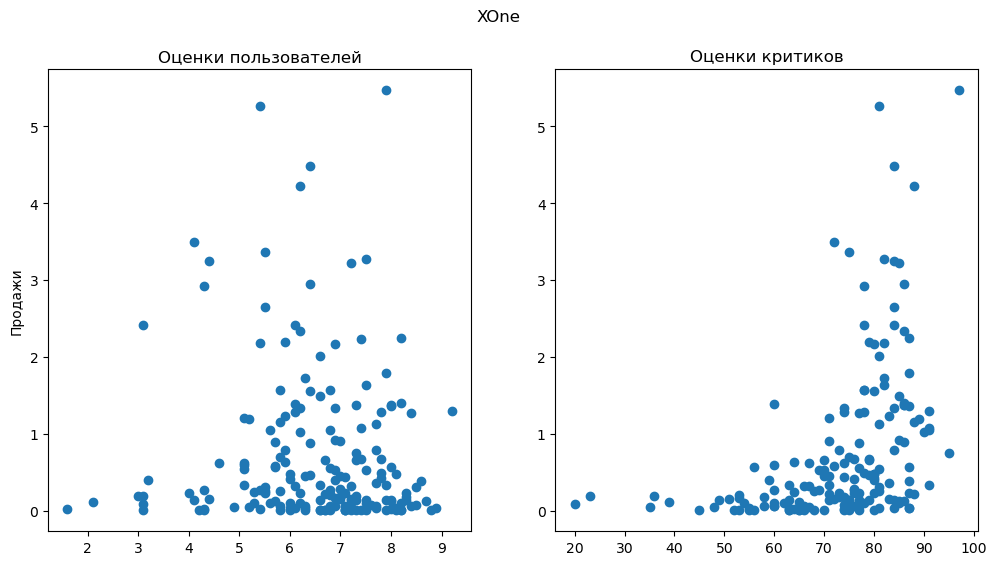

    Корреляция:                                      Корреляция:
    -0.06892505328279414                             0.4169983280084017


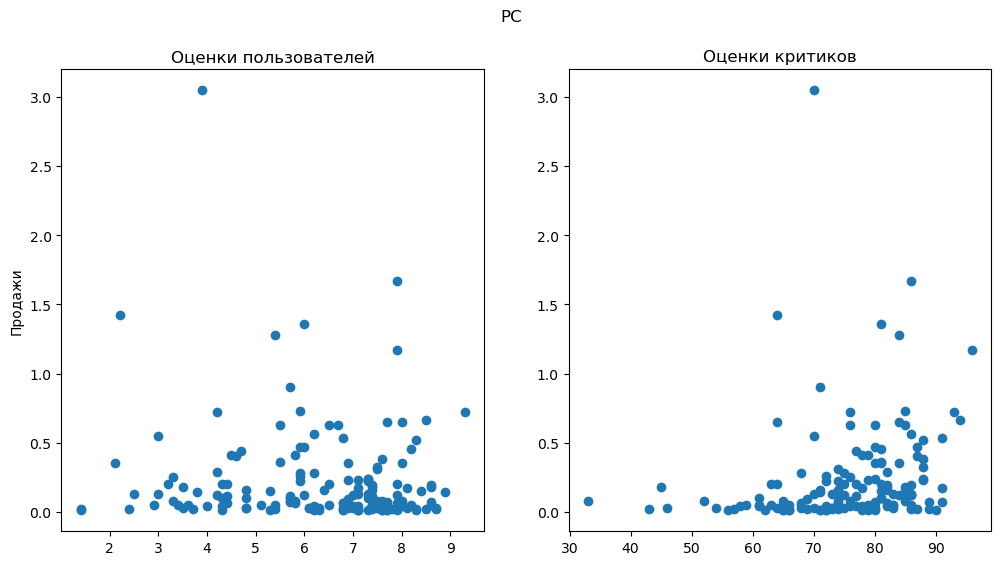

    Корреляция:                                      Корреляция:
    -0.0938418695247674                             0.19603028294369382


In [23]:
platforms = ["PS4", "PS3", "X360", "XOne", "PC"]
data1 = data[data["year_of_release"]>=2013]
for platform in platforms:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(
        data1[(data1["platform"]==platform)&(data1["user_score"]>0)]["user_score"],
        data1[(data1["platform"]==platform)&(data1["user_score"]>0)]["sum_sales"], "o")
    ax2.plot(
        data1[(data1["platform"]==platform)&(data1["critic_score"]>0)]["critic_score"],
        data1[(data1["platform"]==platform)&(data1["critic_score"]>0)]["sum_sales"], "o")
    fig.suptitle(platform)
    fig.set(figheight=6, figwidth=12)
    ax1.set_title("Оценки пользователей")
    ax2.set_title("Оценки критиков")
    ax1.set(ylabel="Продажи")
    plt.show()
    print(" "*3,"Корреляция:"," "*36,"Корреляция:")
    print(" "*3,data1[(data1["platform"]==platform)&(data1["user_score"]>0)]["user_score"].corr(
        data1[(data1["platform"]==platform)&(data1["user_score"]>0)]["sum_sales"])," "*27,
        data1[(data1["platform"]==platform)&(data1["critic_score"]>0)]["critic_score"].corr(
        data1[(data1["platform"]==platform)&(data1["critic_score"]>0)]["sum_sales"]))

Чтобы обощить полученные данные, возьмём все платформы за последние 4 года

In [24]:
for score in ["user_score", "critic_score"]: 
    print(
        data[data['year_of_release']>=2013]["sum_sales"].corr(data[data['year_of_release']>=2013][score])
    )

0.15522662915312715
0.22047338447931925


Как правило, оценки критиков сильнее влияют на продажи, чем оценки пользователей (но до прямой зависимости всё ещё далеко), поэтому при прогнозировании лучше обращать внимание именно на оценки критиков

### Распределение игр по жанрам

Для начала посмотрим на распределение игр по жанрам

In [25]:
data[data["year_of_release"]>=2013].pivot_table(
    index="genre", values="name", aggfunc="count").sort_values(by="name", ascending=False)

,name
genre,
Action,766
Role-Playing,292
Adventure,245
Sports,214
Shooter,187
Misc,155
Racing,85
Fighting,80
Platform,74


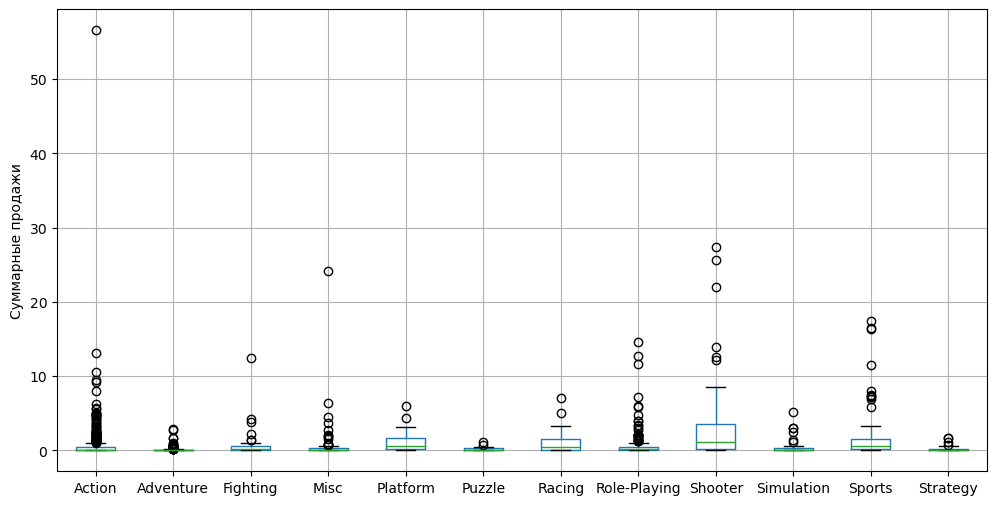

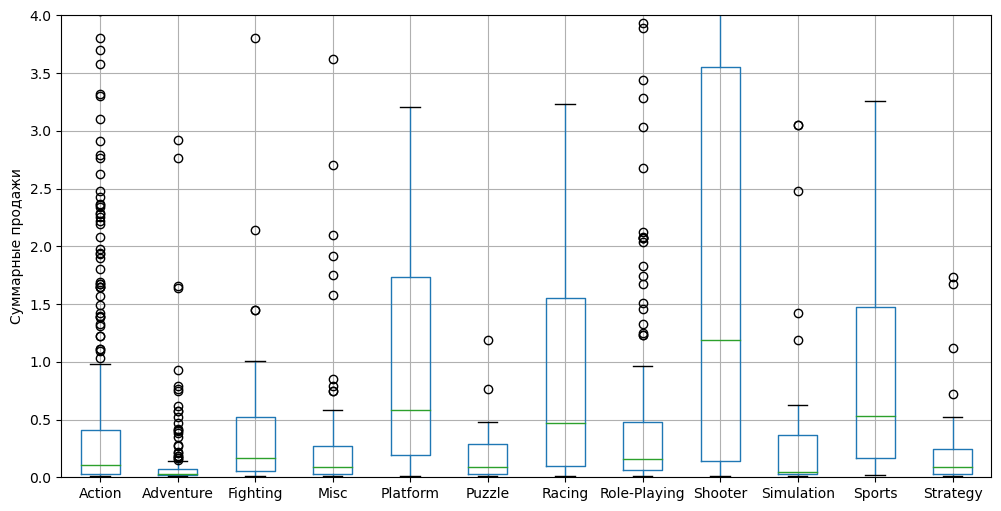

In [26]:
data[data["year_of_release"]>=2013].pivot_table(
    index="name", values="sum_sales", columns = "genre", aggfunc="sum").boxplot(figsize=(12,6))
plt.ylabel("Суммарные продажи")
plt.show()
data[data["year_of_release"]>=2013].pivot_table(
    index="name", values="sum_sales", columns = "genre", aggfunc="sum").boxplot(figsize=(12,6), autorange=True)
plt.ylim(0, 4)
plt.ylabel("Суммарные продажи")
plt.show()

Выделяется жанр Шутер, который одновременно является одним из самый выпускаемых и с высокими медианными продажами. Самые продаваемые жанры - Экшн и Ролплей с низкими медианными продажами, но большими количеством выбросов (выстрелевших игр), поэтому эти жанры является потенциально прибильными, но рискованными.

## Портрет пользователя кажого региона

Будем проволить анализ за последние 4 года (начиная с 2013)

### Севеная Америка

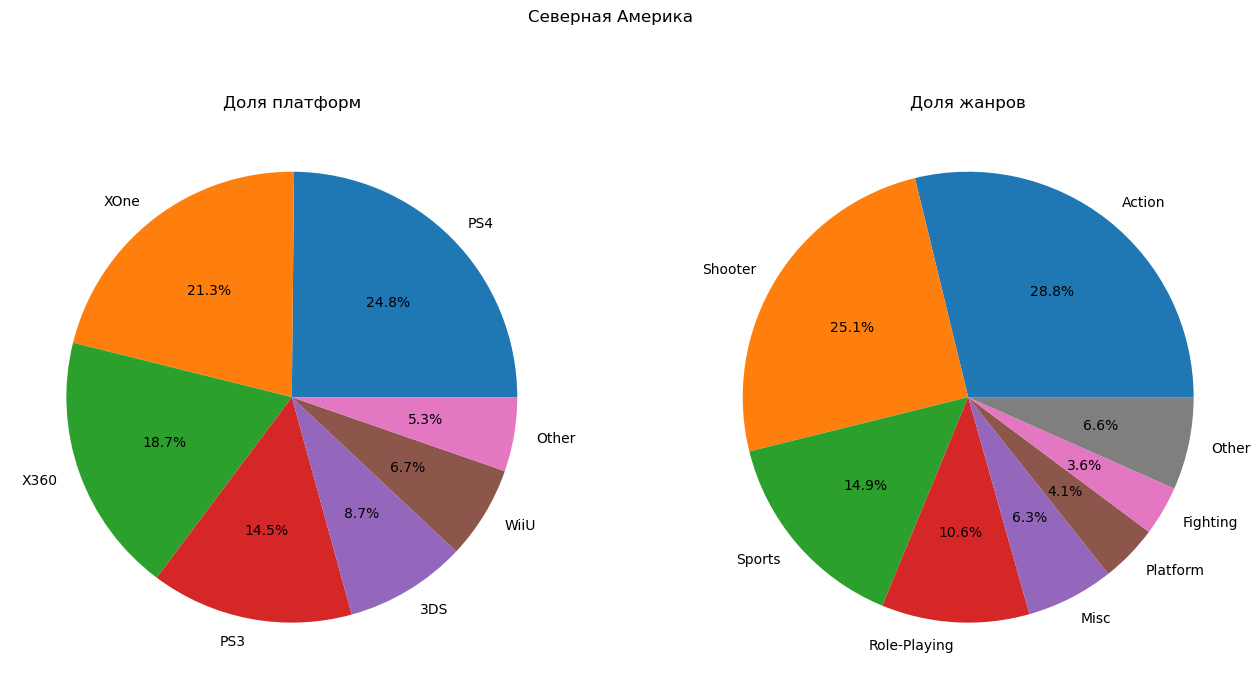

In [27]:

na_platforms = data[data["year_of_release"]>=2013].pivot_table(
    index="platform", values="na_sales", aggfunc="sum"
).sort_values(by="na_sales", ascending=False)

na_platforms.loc["Other"] = na_platforms.loc["PC":].sum()

na_platforms = na_platforms[na_platforms["na_sales"]>na_platforms.loc["PC","na_sales"]]


na_genres = data[data["year_of_release"]>=2013].pivot_table(
    index="genre", values="na_sales", aggfunc="sum"
).sort_values(by="na_sales", ascending=False)
na_genres.loc["Other"] = na_genres.loc["Racing":].sum()

na_genres = na_genres[na_genres["na_sales"]>na_genres.loc["Racing","na_sales"]]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,8))

ax1.pie(na_platforms["na_sales"], autopct='%.1f%%', labels = na_platforms.index)
ax1.set_title("Доля платформ")
ax2.pie(na_genres["na_sales"], autopct='%.1f%%', labels = na_genres.index)
ax2.set_title("Доля жанров")
fig.suptitle("Северная Америка")
plt.show()

Звание самой популярной платформы в Северной Америке делят между собой PS4 и XboxOne почти поровну. Четыре из 5 самых популярных платформ это Xbox или PS.

Самые популярные жанры - Экшн и Шутеры, которые занимают больше половины от всех продаж в Северной Америке

###  Европа

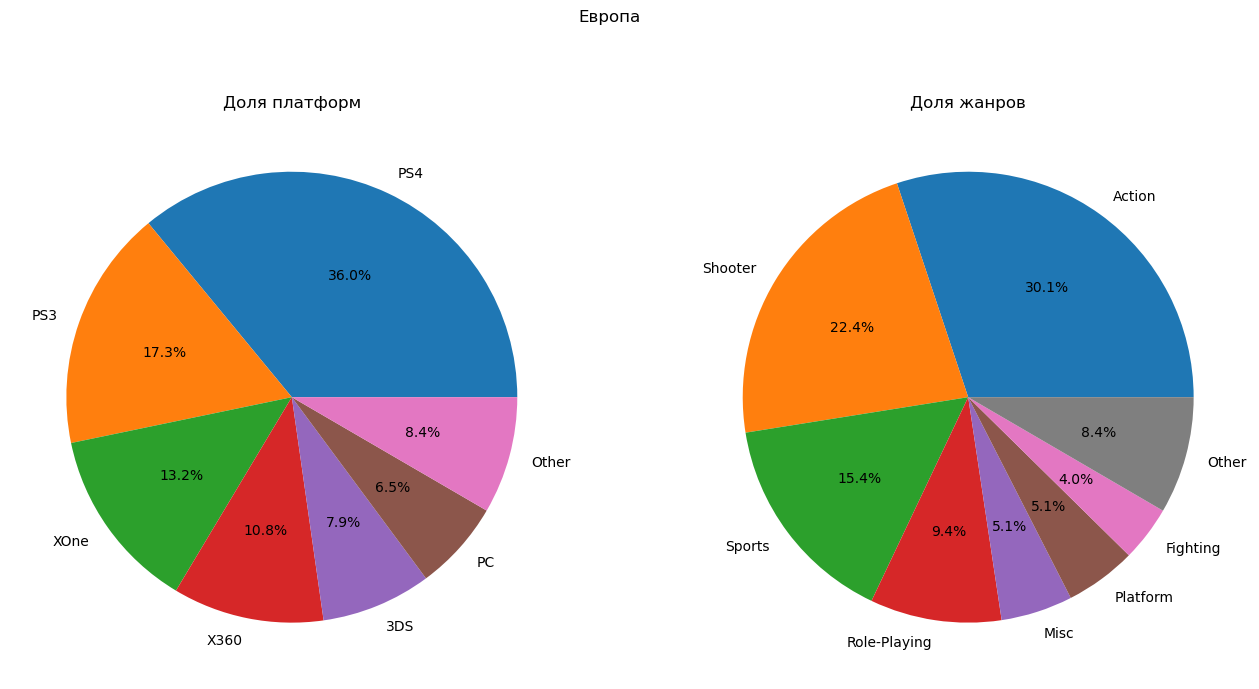

In [28]:
eu_platforms = data[data["year_of_release"]>=2013].pivot_table(
    index="platform", values="eu_sales", aggfunc="sum"
).sort_values(by="eu_sales", ascending=False)
eu_platforms.loc["Other"] = eu_platforms.loc["WiiU":].sum()

eu_platforms = eu_platforms[eu_platforms["eu_sales"]>eu_platforms.loc["WiiU","eu_sales"]]

eu_genres = data[data["year_of_release"]>=2013].pivot_table(
    index="genre", values="eu_sales", aggfunc="sum"
).sort_values(by="eu_sales", ascending=False)
eu_genres.loc["Other"] = eu_genres.loc["Simulation":].sum()

eu_genres = eu_genres[eu_genres["eu_sales"]>eu_genres.loc["Simulation","eu_sales"]]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,8))

ax1.pie(eu_platforms["eu_sales"], autopct='%.1f%%', labels = eu_platforms.index)
ax1.set_title("Доля платформ")
ax2.pie(eu_genres["eu_sales"], autopct='%.1f%%', labels = na_genres.index)
ax2.set_title("Доля жанров")
fig.suptitle("Европа")
plt.show()

В Европе ситуация похожа на Северную Америку, но доля PS4 от общего числа продаж намного выше.

Популярные жанры те же - экшн и шутеры занимают больше половины от общего числа продаж

### Япония

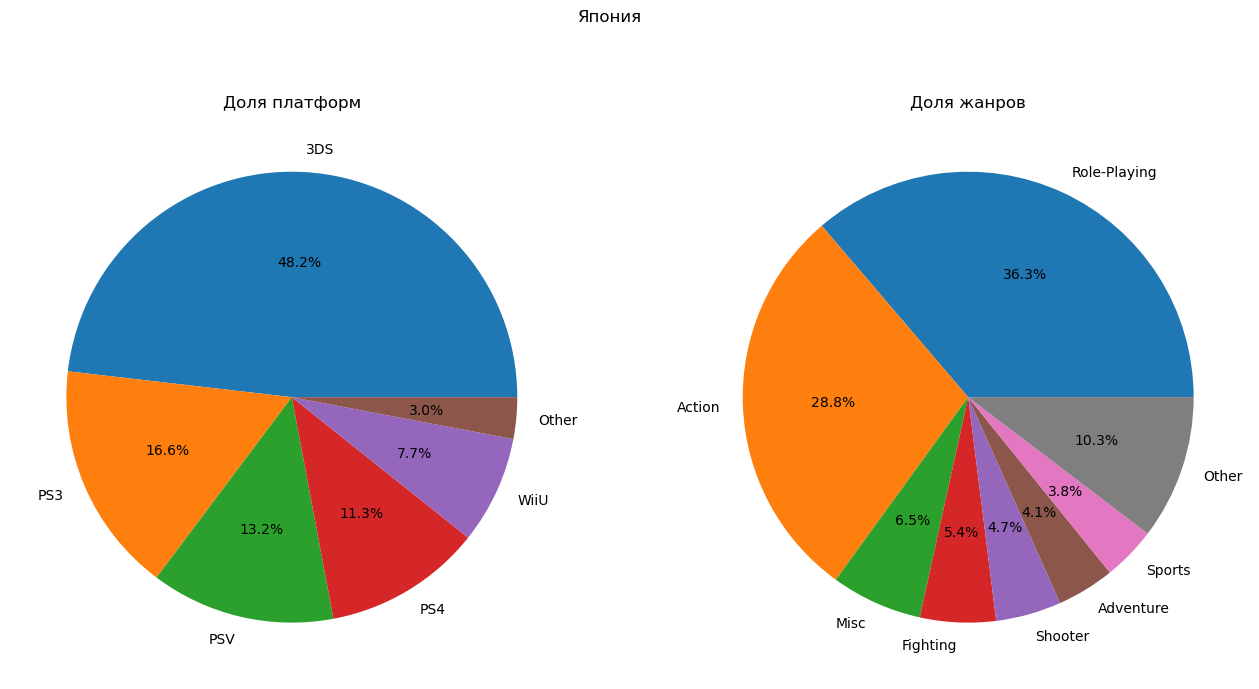

In [29]:
jp_platforms = data[data["year_of_release"]>=2013].pivot_table(
    index="platform", values="jp_sales", aggfunc="sum"
).sort_values(by="jp_sales", ascending=False)
jp_platforms.loc["Other"] = jp_platforms.loc["PSP":].sum()
jp_platforms = jp_platforms[jp_platforms["jp_sales"]>jp_platforms.loc["PSP","jp_sales"]]

jp_genres = data[data["year_of_release"]>=2013].pivot_table(
    index="genre", values="jp_sales", aggfunc="sum"
).sort_values(by="jp_sales", ascending=False)
jp_genres.loc["Other"] = jp_genres.loc["Platform":].sum()

jp_genres = jp_genres[jp_genres["jp_sales"]>jp_genres.loc["Platform","jp_sales"]]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,8))

ax1.pie(jp_platforms["jp_sales"], autopct='%.1f%%', labels = jp_platforms.index)
ax1.set_title("Доля платформ")
ax2.pie(jp_genres["jp_sales"], autopct='%.1f%%', labels = jp_genres.index)
ax2.set_title("Доля жанров")
fig.suptitle("Япония")
plt.show()

В Японии ситуация совсем иная - самая популярная платформа 3DS занимает почти половину продаж, в то время как популярная в Европе и Северной Америке PS4 не входит даже в первую тройку

По жанрам тоже имеются сущесвенные отличия - самый популярный ролплей и экшн, которые вместе дают 65 процентов от всех продаж

### Рейтинг ESRB

Рассмотрим медианные продажи в зависимости от рейтинга и региона

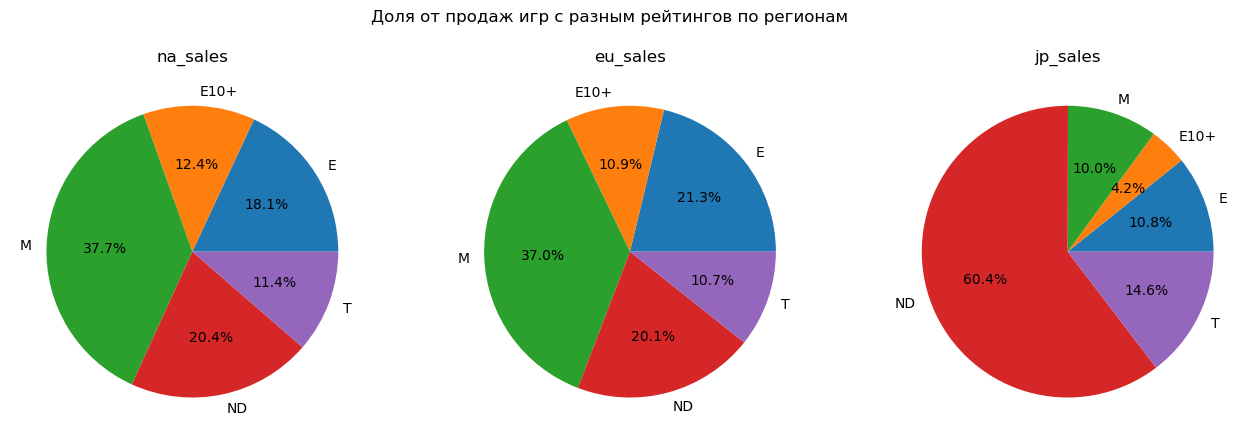

In [30]:
i =0
fig, ax = plt.subplots(1, 3,figsize=(16,5))
for sales in ["na_sales", "eu_sales", "jp_sales"]:
    ax[i].pie(data[data["year_of_release"]>=2013].pivot_table(
        index="rating", values = sales, aggfunc="sum")[sales],
              autopct='%.1f%%', labels = data[data["year_of_release"]>=2013].pivot_table(
        index="rating", values = sales, aggfunc="sum").index)
    ax[i].set_title(sales)
    fig.suptitle("Доля от продаж игр с разным рейтингов по регионам")
    i+=1

В Японии очень высокий процент игр, рейтинг которых неопределён, поэтому что-то анализировать с помощью рейтинга в этом регионе бессмысленно. Но для Северной Америки и Европы можно посмотреть медианные продажи по рейтингу.

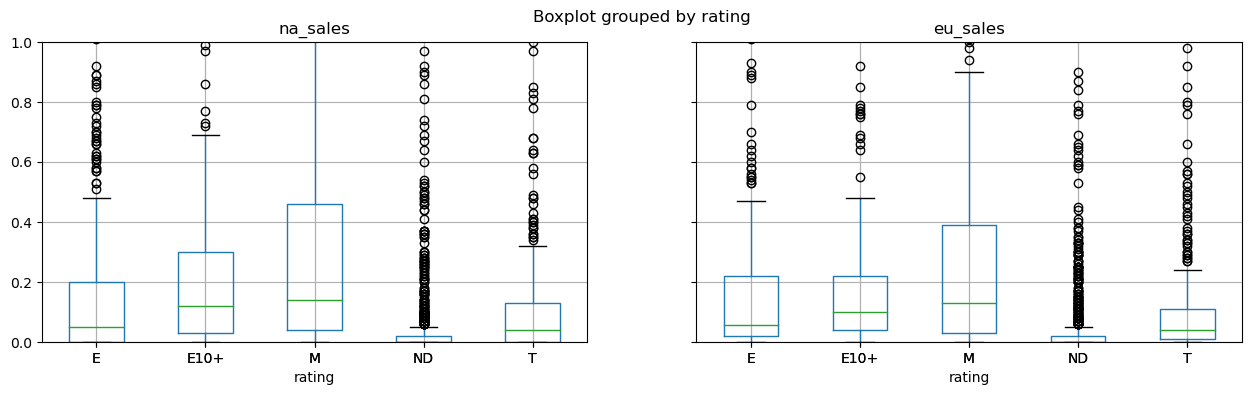

In [31]:
data[data["year_of_release"]>=2013].boxplot(by="rating", column=["na_sales", "eu_sales"], figsize=(15,4))
plt.ylim(0,1)
plt.show()

В Европе и Америке ситуации очень похожи. Рейтинг с самыми большими медианными продажами и самой большой долей на рынке - M (Mature, Для взростых). В Японии игры в основном не маркируются ESRB, поэтому и проводить анализ на рейтинге некорректно.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

```
Нулевая гипотеза: Средние пользовательские рейтинги (user_score) платформ Xbox One и PC одинаковые.
Альтернативная гипотеза: Средние пользовательские рейтинги (user_score) платформ Xbox One и PC различны.
alpha = 0.05
```

In [32]:
alpha = .05
result = st.ttest_ind(
    data[(data["year_of_release"]>=2013)&(data["platform"]=="XOne")&(data["user_score"]>0)]["user_score"], 
    data[(data["year_of_release"]>=2013)&(data["platform"]=="PC")&(data["user_score"]>0)]["user_score"], 
    equal_var = False)

print(result.pvalue)
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("Не можем отвергнуть нулевую гипотезу")
        

0.14759594013430463
Не можем отвергнуть нулевую гипотезу


Гипотеза не может быть отвергнута, то есть средние пользовательские рейтинги платформ Xbox One и PC одинаковы

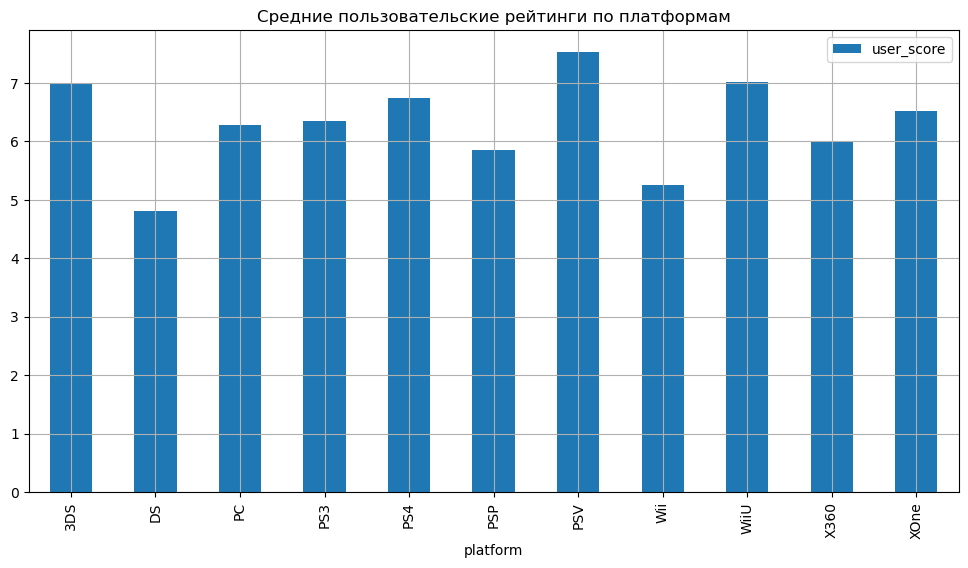

In [33]:
data[(data["year_of_release"]>=2013)&(data["user_score"]>0)].pivot_table(
    index="platform",values="user_score").plot(kind="bar", figsize=(12,6), grid=True)
plt.title("Средние пользовательские рейтинги по платформам")
plt.show()

Действительно, у PC и XboxOne средние пользовательские рейтинги очен схожи

### Средние пользовательские рейтинги жанров экшн и спорт разные.

```
Нулевая гипотеза: Средние пользовательские рейтинги (user_score) жанров Action и Sports одинаковые.
Альтернативная гипотеза: Средние пользовательские рейтинги (user_score) жанров Action и Sports различны.
alpha = 0.05
```

In [34]:
alpha = .05
result = st.ttest_ind(
    data[(data["year_of_release"]>=2013)&(data["genre"]=="Action")&(data["user_score"]>0)]["user_score"], 
    data[(data["year_of_release"]>=2013)&(data["genre"]=="Sports")&(data["user_score"]>0)]["user_score"],  
    equal_var = False)

print(result.pvalue)
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("Не можем отвергнуть нулевую гипотезу")

1.4460039700704315e-20
Отвергаем нулевую гипотезу в пользу альтернативной


Гипотеза подтвердилась, то есть средние пользовательские рейтинги жанров Action и Sports различны

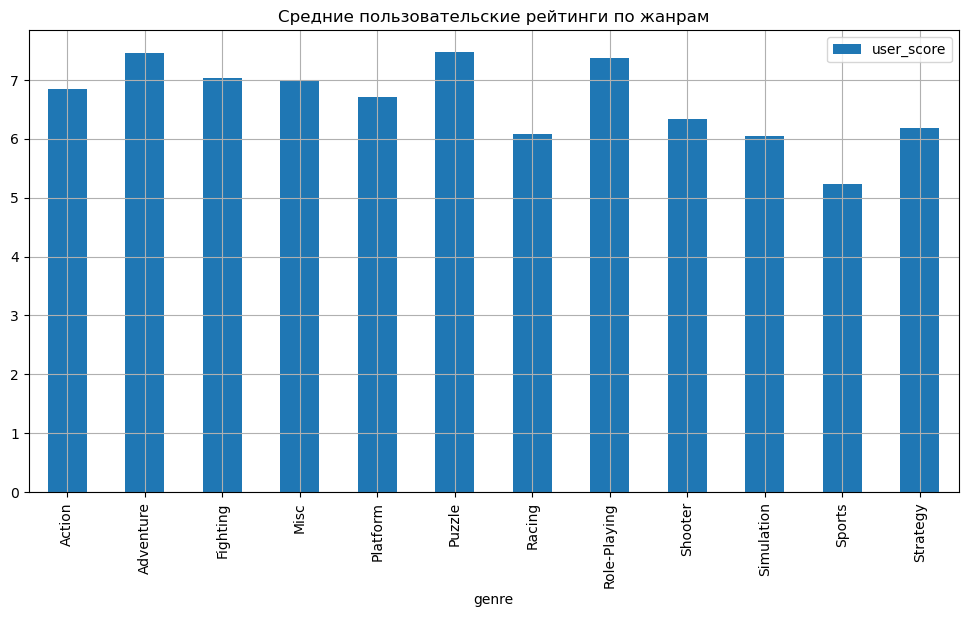

In [35]:
data[(data["year_of_release"]>=2013)&(data["user_score"]>0)].pivot_table(
    index="genre",values="user_score").plot(kind="bar", figsize=(12,6), grid=True)
plt.title("Средние пользовательские рейтинги по жанрам")
plt.show()

На этой диаграмме видно, что средние пользовательские рейтинги Action и Sports действительно разные

При проверке равенства средних двух генеральных совокупностей нулевую гипотезу следует формулировать как утверждение о том, что средние равны (A = Б). Альтернативная гипотеза формулируется как отрицание нулевой (A != Б, A > Б или A < Б). В нашем случае не стояло вопроса о том, какое среднее больше, поэтому мы сформулировали альтернативную гипотезу как двухстороннюю. Уровень статистической значимости alpha был принят на уровне 5%, то есть если нулевая гипотеза верна, то шанс получить текущую и большую разность средних значений выборок должен превышать 5%

## Общий вывод

В ходе анализа выяснилось, что динамика продаж игр за последние 4 года менялась не сильно, поэтому для прогнозировния нужно использовать только их. Игровая платформа проходит примерно одинаковый для всех "жизненный цикл" длиной в среднем 10 лет. В 2016 году набирали популярность Xbox One и PS4, поэтому в следующем году ставку необходимо делать на них. Коррелиции между оценками пользователей и суммарными продажами не обнаружено, но корреляция между оценками критиков и суммарными продажами присутсвует, поэтому при прогнозировании продаж, необходимо учитывать оценки критиков. В ходе анализа жанров выпускаемых игр было обнаружено, что самые популярные жанры имеют очень низкие медианные суммарные продажи, но сущесвуют также жанры средней популярности, но с относительно высокими медианными продажами - Спорт и Шутер. Это стабильные жанры. Были проанализированы популярные жанры и платформы для разных регионов. В Северной Америке и Европе портреты очень схожи - самые популярные платформы Xbox или  PS, самые популярные жанры - Экшн и Шутер. В Японии ситуация иная, там самая популярная платформа - 3DS, самый популярный жанр - Рол-плей.